In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import glob
import subprocess

In [2]:
with open("EVCS_15_B.gms","r") as f:
    list_of_lines = f.readlines()
    
    
list_of_lines[134]

'eq_electricity_cost.. var_electricity_cost =E= (sum(m, var_grid_energy(m) * electricity_prices(m)) + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2)) *0.5\n'

In [3]:
list_of_lines[35]

'$include demand_winter.tsv\n'

In [4]:
el_price = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

In [5]:
len(el_price)

12

In [6]:
for i in range(len(el_price)):
    
    with open("EVCS_15_B.gms","r") as f:
        list_of_lines = f.readlines()
        
    list_of_lines[35] = '$include demand_winter.tsv\n'
    
    list_of_lines[134] = "eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *" + str(el_price[i]) + ") + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2 *" + str(el_price[i]) + ") \n"
    
    
    print(list_of_lines[134])
    
    with open("EVCS_15_B.gms", "w") as f:
        f.writelines(list_of_lines)
        
    subprocess.run(["gams", "EVCS_15_B.gms", "logOption", "2"])
    
    subprocess.run(["move", "EVCS_15_B_results.db", "EVCS_15_B_results_" + str(el_price[i]) + ".db"], shell = True)
    
    print(el_price[i])

eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *0.25) + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2 *0.25) 

0.25
eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *0.5) + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2 *0.5) 

0.5
eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *0.75) + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2 *0.75) 

0.75
eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *1) + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2 *1) 

1
eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *1.25) + sum(m, var_grid_ex_energy(m) * electricity_prices(m) * 2 *1.25) 

1.25
eq_electricity_cost.. var_electricity_cost =E= sum(m, var_grid_energy(m) * electricity_prices(m) *1.5) + sum(m, var_grid_ex_ene

In [10]:
#Extract result data from all result databases and create dataframes for each variable

grid_p = pd.DataFrame()
grid_ex_p = pd.DataFrame()
grid_tot_p = pd.DataFrame()

soc_pen = pd.DataFrame()

grid_e = pd.DataFrame()
grid_ex_e = pd.DataFrame()

ESS_lvl = pd.DataFrame()
ESS_p = pd.DataFrame()

sclrs = pd.DataFrame()

for filename in glob.glob('EVCS_15_B_results*.db'):
    con = sqlite3.connect(filename)
    
    grid_power = pd.read_sql_query("SELECT * FROM var_grid_power", con)
    grid_extra_power = pd.read_sql_query("SELECT * FROM var_grid_ex_power", con)
    grid_total_power = pd.read_sql_query("SELECT * FROM var_grid_total_power", con)
    
    grid_energy = pd.read_sql_query("SELECT * FROM var_grid_energy", con)
    grid_extra_energy = pd.read_sql_query("SELECT * FROM var_grid_ex_energy", con)
    
    ESS_level = pd.read_sql_query('SELECT * FROM var_ESS_level', con)
    ESS_power = pd.read_sql_query('SELECT * FROM var_ESS_power', con)
    
    scalars =  pd.read_sql_query('SELECT * FROM scalarvariables', con)
    
    soc_penalty = pd.read_sql_query('SELECT * FROM var_SOC_pen', con)
    
    con.close()
    
    grid_p[filename[18:-3]] = grid_power['level'].copy()
    grid_ex_p[filename[18:-3]] = grid_extra_power['level'].copy()
    grid_tot_p[filename[18:-3]] = grid_total_power['level'].copy()
    
    grid_e[filename[18:-3]] = grid_energy['level'].copy()
    grid_ex_e[filename[18:-3]] = grid_extra_energy['level'].copy() 
    
    ESS_lvl[filename[18:-3]] = ESS_level['level'].copy()
    ESS_p[filename[18:-3]] = ESS_power['level'].copy()  
    
    sclrs[filename[18:-3]] = scalars['level'].copy()
    
    soc_pen[filename[18:-3]] = soc_penalty['level'].copy()



In [12]:
#Scalar variables are collected in one DF. In this cell this df is cleaned and sorted

sclrs = sclrs.set_index(scalars['name'])
sclrs1 = sclrs.T
sclrs1['var_ESS_size'] = sclrs1['var_ESS_size'] * 1.25
sclrs1.index = sclrs1.index.astype(float)
sclrs1 = sclrs1.sort_index(ascending = True)
sclrs1['ElPrice Multiplier'] = np.array(el_price)
sclrs1

name,var_ess_rated_power,var_grid_maxpower1,var_grid_maxpower2,var_grid_maxpower3,var_grid_maxpower4,var_ESS_cost,var_electricity_cost,var_grid_tariff_winter,var_energy_tax,months,var_system_cost,var_ESS_size,ElPrice Multiplier
0.25,173.968750,222.591250,264.807500,180.000000,225.501250,30618.500000,35979.223606,70614.112924,3602.265477,4.283482,143655.748298,173.968750,0.25
0.50,173.968750,222.591250,264.807500,180.000000,225.501250,30618.500000,71175.575716,70578.010614,3602.265477,4.283482,179416.938786,173.968750,0.50
0.75,173.968750,222.591250,264.807500,180.000000,225.501250,30618.500000,106185.715327,70562.178626,3602.265477,4.283482,214894.052076,173.968750,0.75
1.00,173.968750,222.591250,264.807500,180.000000,225.501250,30618.500000,141094.161756,70553.808901,3602.265477,4.283482,250226.077156,173.968750,1.00
1.25,175.547230,221.012770,264.201364,179.191818,223.922770,30896.312500,175891.665391,70227.755937,3602.265477,4.283482,285445.390587,175.547230,1.25
1.50,177.494709,219.065291,263.453532,178.194709,221.975291,31239.068783,210719.777209,69829.618072,3602.265477,4.283482,320594.514786,177.494709,1.50
1.75,178.970000,217.590000,262.887020,177.439360,220.500000,31498.720000,245423.772937,69528.258346,3602.265477,4.283482,355682.890064,178.970000,1.75
2.00,179.257177,217.302823,262.776744,177.292326,220.212823,31549.263081,280155.763063,69468.727326,3602.265477,4.283482,390723.839720,179.257177,2.00
2.25,181.281250,215.278750,261.999500,176.256000,218.188750,31905.500000,314893.805398,69057.448564,3602.265477,4.283482,425727.665693,181.281250,2.25
2.50,182.823509,213.736491,261.407273,175.466364,216.646491,32176.937500,349508.407957,68743.890241,3602.265477,4.283482,460696.809641,182.823509,2.50


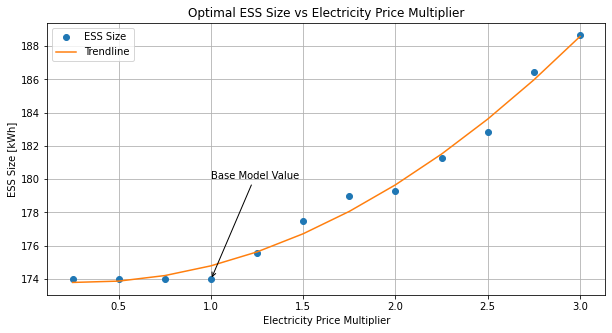

In [17]:
arrowprops = dict(arrowstyle = "->")

x = sclrs1['ElPrice Multiplier']
y = sclrs1['var_ESS_size']

m = np.polyfit(x,y, 2)

plt.figure(figsize = (10,5))
plt.plot(x,y,'o', label = 'ESS Size')
plt.plot(x, m[0]*x**2+m[1]*x+m[2], '-', label = 'Trendline')
plt.annotate('Base Model Value', xy= (x.iloc[3],y.iloc[3]), arrowprops = arrowprops, xytext = (1,180))
plt.xlabel('Electricity Price Multiplier')
plt.ylabel('ESS Size [kWh]')
plt.title('Optimal ESS Size vs Electricity Price Multiplier')
plt.legend(loc = 'upper left')
plt.grid()

Text(0.5, 1.0, 'Case B Optimal Solution Cost Results')

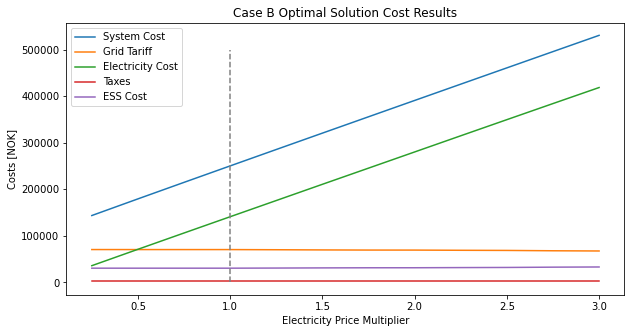

In [26]:
s = sclrs1['var_system_cost']
gt = sclrs1['var_grid_tariff_winter']
e = sclrs1['var_electricity_cost']
tx = sclrs1['var_energy_tax']
b = sclrs1['var_ESS_cost']
i = [1,1]
o = [0,500000]


plt.figure(figsize= (10,5))
plt.plot(x,s, label = 'System Cost')
plt.plot(x,gt, label = 'Grid Tariff')
plt.plot(x,e, label = 'Electricity Cost')
plt.plot(x,tx, label = 'Taxes')
plt.plot(x,b, label = 'ESS Cost')
plt.plot(i,o, '--', color = 'gray')
plt.legend()
plt.xlabel('Electricity Price Multiplier')
plt.ylabel('Costs [NOK]')
plt.title('Case B Optimal Solution Cost Results')